<a href="https://colab.research.google.com/github/ThuanPhong0126/CS114.K21/blob/master/Project/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Kết nối google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

Import các thư viện cần thiết

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load dữ liệu được lưu trên github

In [ ]:
df=pd.read_excel('https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/final_data.xlsx?raw=true')
df

,Unnamed: 0,text,label
0,0,Không có chào đón như trong giới thiệu,0
1,1,"Lựa chọn tốt cho du lịch nhóm ,gia đình",1
2,2,"phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.",1
3,3,phòng sạch đẹp,1
4,4,"Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...",1
...,...,...,...
4119,145,Thôi thì treo biển không nhận khách đi oto cho...,0
4120,146,12 giờ đêm về thì khách sạn tối hin,0
4121,147,Nói 3 sao thì hơi quá.,0
4122,148,"Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.",0


Dữ liệu gồm có 3 cột là Unnamed: 0, text và label. Trong đó text chứ bình luận, label chứa nhãn tương ứng và cột Unnamed: 0 không có tác dụng nên xóa cột Unnamed: 0

In [ ]:
del df['Unnamed: 0']
df

,text,label
0,Không có chào đón như trong giới thiệu,0
1,"Lựa chọn tốt cho du lịch nhóm ,gia đình",1
2,"phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.",1
3,phòng sạch đẹp,1
4,"Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...",1
...,...,...
4119,Thôi thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách sạn tối hin,0
4121,Nói 3 sao thì hơi quá.,0
4122,"Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.",0


Trong bộ data có tất cả 4124 bình luận.

Biểu đồ thống kê số lượng nhãn tương ứng với mỗi label

1    2476
0    1648
Name: label, dtype: int64


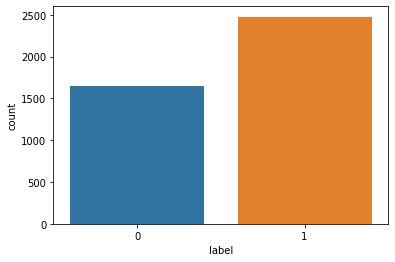

In [ ]:
print(df['label'].value_counts())
sns.countplot(df['label'])
plt.show()

**Nhận xét:** Trong bộ data có tất cả 4124 câu bình luận trong đó bình luận tích cực (label 1) là 2476 bình luận (chiếm 60,04%) và bình luận tiêu cực (label 0) là 1648 bình luận (chiếm 39,96%).

* Thư viện pyvi được cài đặt để sử dụng cho việc phân chia từ trong tiếng việt

In [ ]:
!pip install pyvi

In [ ]:
from pyvi import ViTokenizer
def Token(t):
  return ViTokenizer.tokenize(t)

def standardize_data(t):

  t = t.lower()
  t = t.replace(',', ' ').replace('.', ' ')\
      .replace(";", " ").replace("“", " ") \
      .replace(":", " ").replace("”", " ") \
      .replace('"', " ").replace("'", " ") \
      .replace("!", " ").replace("?", " ").replace("-", " ").replace("?", " ") 
  t = t.strip()
  return t

* Hàm Token có nhiệm vụ thực hiện việc phân chia các từ trong tiếng việt.
Ví dụ:

In [ ]:
print(Token('Khách sạn nằm ở vị trí trung tâm của thành phố'))

Khách_sạn nằm ở vị_trí trung_tâm của thành_phố


* Hàm standardize_data nhận đầu vào là một bình luận và nó có nhiệm vụ chuyển bình luận về chữ thường, xóa các dấu câu đặc biệt (, . ; " : ' ! ? -) và xóa các khoảng trống ở đâu và cuối bình luận. Ví dụ:

In [ ]:
print(standardize_data('kHÁCH sạn này có vị trí thuận tiện Đi lại!!!   '))

khách sạn này có vị trí thuận tiện đi lại


### Không phân tích theo nghĩa tiếng việt _ phân theo dấu cách

Thực hiện hàm standardize_data trên tất cả các bình luận có trong bộ dữ liệu. Và thu được một dataframe mới như bên dưới.

In [ ]:
df['text'] = df['text'].apply(standardize_data)
df

,text,label
0,không có chào đón như trong giới thiệu,0
1,lựa chọn tốt cho du lịch nhóm gia đình,1
2,phòng yên tĩnh dù sát mặt đường lớn sạch sẽ,1
3,phòng sạch đẹp,1
4,khách sạn sạch sẽ gần biển gần siêu thị lott...,1
...,...,...
4119,thôi thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách sạn mình ở nha trang vẫn 3 sao,0


In [ ]:
X_tr, X_t, y_train, y_test =train_test_split(df['text'], df['label'], test_size=0.2, random_state=0)

Phân chia dữ liệu với 80% làm tập train và 20% làm tập test

In [ ]:
X_t

1065     phòng đẹp  buffe sáng ngon  nhân viên thân thiện
45      nhân viên phục vụ ăn sáng có thái độ  tôi xuốn...
2411            phòng sạch sẽ  giường rất êm và thoải mái
1280                                   địa điểm thuận lợi
1784    chúng tôi ở sanouva 6 ngày  the complimentary ...
                              ...                        
2506                            phòng đẹp  rộng và thoáng
177                                            phục vụ tệ
50      khách sạn sạch sẽ  nhân viên nhiệt tình  gần t...
64              vòi sen phòng mình bị hư và chảy rất chậm
1507    đặc biệt các bạn nhân viên ở đây thân thiện ch...
Name: text, Length: 825, dtype: object

Tập test có 825 bình luận

In [ ]:
X_tr

3462    chỗ chờ không có quạt  nên hơi ngộp và giường ...
866     mọi thứ đều ổn  vệ sinh có vẻ chưa tốt lắm  vẫ...
2058                                 nhân viên thân thiện
3908    những chi tiết nhỏ đó có rơi xuống đất ...
3267    mình mướn phòng vào ngày mưa  trần nhà bị dột ...
                              ...                        
1033    giá hơi cao  nhưng được cái phòng đẹp và vị tr...
3264            nhân viên nói chuyện trỗng  thiếu văn hóa
1653            đây là lần 2 tôi đặt phòng tại white sand
2607    tôi đã từng ở adaline hồi khách sạn mới mở   ấ...
2732    mọi thứ đều mini trừ giá cả  giao phòng không ...
Name: text, Length: 3299, dtype: object

Tập train có 3299 bình luận

Tiêp theo đến việc chuyển các bình luận về các vector đặc trưng.


#### TF-IDF

Phương pháp đầu tiên sử dụng là TF-IDF. Phương pháp này sẽ tạo ra một túi từ vựng bằng tất cả các từ có trong bộ dữ liệu. Sau đó chuyển các bình luận về dạng vector đặc trung với mỗi vector có độ dài bằng số lượng từ vựng trong túi từ vựng và tính độ quan trọng của mỗi từ trong túi từ vựng đối với bình luận đang xét. Và phương pháp tính Tf-idf được hỗ trợ bởi thư viện scikit-learn

In [ ]:
emb=TfidfVectorizer()
emb.fit(df['text'])
X_train=emb.transform(X_tr)
X_test=emb.transform(X_t)

Emb được lưu lại để sử dụng cho việc sau này như việc dự đoán một câu bất kỳ được nhập vào. Và file này sẽ được upload lên github cho việc sử dụng thuận tiện hơn.

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_cach.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_cach.pkl']

##### Lựa chọn model

Lựa chọn model, sử dụng 5 model: BernoulliNB, Logistic Regression,SVC, Randomforest, Decision Tree cho mỗi phương pháp feature engineering khác nhau. Và từ đó so sánh và chọn ra model tốt nhất.

**Model đầu tiên: BernoulliNB**

In [ ]:
model=BernoulliNB()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy:  ',accuracy_score(y_test,predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:   0.8896969696969697
Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       347
           1       0.89      0.93      0.91       478

    accuracy                           0.89       825
   macro avg       0.89      0.88      0.89       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[291  56]
 [ 35 443]]


*Accuracy*: 88,96% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 86% và 91% với 

f1-score=2 x (recall x precision)/(recall + precision) trong đó: 

recall nhãn 0 = (số lượng bình luận nhãn 0 được model dự đoán chính xác) / (số lượng bình luận nhãn  trong thực tế)

precision nhãn 0 = (số lượng bình luận nhãn 0 được model dự đoán chính xác) / (số lượng bình luận nhãn 0 được model dự đoán)

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89. (0.89= 0.86.(347/825)+0.91.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 291 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 443 bình luận => accuracy = (291+443) / 825 = 0,8896

---



**Model thứ hai: LogisticRegression**

In [ ]:
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification-report: \n',classification_report(y_test,predict))
print('Confusion_matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9466666666666667
Classification-report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       347
           1       0.96      0.95      0.95       478

    accuracy                           0.95       825
   macro avg       0.94      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

Confusion_matrix: 
 [[329  18]
 [ 26 452]]


*Accuracy*: 94.67% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 94% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.95 với (0.95= 0.94.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 327 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 454 bình luận => accuracy = (327+454) / 825 = 0,9467

---

**Model thứ ba: RandomForest**


In [ ]:
model=RandomForestClassifier()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification-report: \n',classification_report(y_test,predict))
print('Confusion_matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9321212121212121
Classification-report: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       347
           1       0.94      0.95      0.94       478

    accuracy                           0.93       825
   macro avg       0.93      0.93      0.93       825
weighted avg       0.93      0.93      0.93       825

Confusion_matrix: 
 [[316  31]
 [ 25 453]]


*Accuracy*: 93,21% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 92% và 94% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.93 với (0.93= 0.92.(347/825)+0.94.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 316 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 453 bình luận => accuracy = (316+453) / 825 = 0,9321

---

**Model thứ tư: SVC**


In [ ]:
model=SVC()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification-report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9527272727272728
Classification-report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       347
           1       0.97      0.95      0.96       478

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

Confusion matrix: 
 [[332  15]
 [ 24 454]]


*Accuracy*: 95,27% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 94% và 96% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.95 với (0.95= 0.94.(347/825)+0.96.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 332 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 454 bình luận => accuracy = (332+454) / 825 = 0,9527

---

**Model thứ năm Decision Tree**

In [ ]:
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test,predict))
print('Clasification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.8715151515151515
Clasification report: 
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       347
           1       0.89      0.89      0.89       478

    accuracy                           0.87       825
   macro avg       0.87      0.87      0.87       825
weighted avg       0.87      0.87      0.87       825

Confusion matrix: 
 [[293  54]
 [ 52 426]]


*Accuracy*: 87,15% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 85% và 89% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.87 với (0.87= 0.85.(347/825)+0.89.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 293 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 426 bình luận => accuracy = (293+426) / 825 = 0,8715

---

Trong 5 model thử với trường hợp tách từ theo dấu cách và kỹ thuật TF-IDF thì model SVC thu được độ chính xác cao nhất (95,27%)

 #### CountVectorizer

Phương pháp thứ hai dùng để chuyển các bình luận về vector đặc trưng là CountVectorizer. Phương pháp này sẽ tạo ra một túi từ vựng gồm tất cả từ vựng có trong các bình luận. Mỗi bình luận sẽ được chuyển về một vector có độ dài bằng số lượng từ trong túi từ vựng, với v là vector của bình luận và v[i] là số lượng của từ thứ i trong túi từ vựng có trong bình luận.

In [ ]:
emb=CountVectorizer().fit(df['text'])
X_train=emb.transform(X_tr)
X_test=emb.transform(X_t)

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/countvr_cach.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/countvr_cach.pkl']

Vẫn sẽ thử với 5 model tương tự như phần TF-IDF

Và cả 5 model sau đây đều thử cùng với tập train/ test ở bên trên với tập test có 504 bình luận nhãn 1 và 321 bình luận nhãn 0

**Model BernoulliNB**

In [ ]:
model=BernoulliNB().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.8896969696969697
Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       347
           1       0.89      0.93      0.91       478

    accuracy                           0.89       825
   macro avg       0.89      0.88      0.89       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[291  56]
 [ 35 443]]


*Accuracy*: 88,97% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 86% và 91%

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89 với (0.89= 0.86.(347/825)+0.91.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 291 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 443 bình luận => accuracy = (291+443) / 825 = 0,8896

---

**Model SVC**

In [ ]:
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Clasification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.936969696969697
Clasification report: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       347
           1       0.96      0.93      0.94       478

    accuracy                           0.94       825
   macro avg       0.93      0.94      0.94       825
weighted avg       0.94      0.94      0.94       825

Confusion matrix: 
 [[329  18]
 [ 34 444]]


*Accuracy*: 93,69% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 93% và 94% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.94 với (0.94= 0.93.(347/825)+0.94.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 329 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 444 bình luận => accuracy = (329+444) / 825 = 0,9369

---

**Model RandomForest**

In [ ]:
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9418181818181818
Classification: 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       347
           1       0.96      0.94      0.95       478

    accuracy                           0.94       825
   macro avg       0.94      0.94      0.94       825
weighted avg       0.94      0.94      0.94       825

Confusion matrix: 
 [[326  21]
 [ 27 451]]


*Accuracy*: 94,18% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 93% và 95%

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.94 với (0.94= 0.93.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 326 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 451 bình luận => accuracy = (326+451) / 825 = 0,9418

---

**Model Decision Tree**

In [ ]:
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.8872727272727273
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       347
           1       0.90      0.91      0.90       478

    accuracy                           0.89       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[298  49]
 [ 44 434]]


*Accuracy*: 88,73% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 87% và 90% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89 với (0.89= 0.87.(347/825)+0.90.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 298 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 434 bình luận => accuracy = (298+434) / 825 = 0.8872

---

**Model Logistic Rrgression**

In [ ]:
model=LogisticRegression().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9357575757575758
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       347
           1       0.93      0.96      0.95       478

    accuracy                           0.94       825
   macro avg       0.94      0.93      0.93       825
weighted avg       0.94      0.94      0.94       825

Confusion matrix: 
 [[315  32]
 [ 21 457]]


*Accuracy*: 93,57% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 92% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.94 với (0.94= 0.92.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 315 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 457 bình luận => accuracy = (315+457) / 825 = 0,9357

---

Vậy trong 5 model thử với phương pháp tách câu theo dấu cách công với phương pháp  CountVectorizer thì model Random Forest thu được độ chính xác cao nhất với accuracy= 0.9418 và f1 là 0.94

### Pyvi

Tuy nhiên trong Tiếng việt thì các từ không chỉ gồm một tiếng mà có thể gồm nhiều tiếng như từ khách sạn, nhân viên nên có một phương pháp tách từ khác được thử, đó là Pyvi.

Chỉnh sửa các bình luận với hai hàm được cài đặt sẵn đó là standarize và Token (2 hàm đã được miêu tả bên trên)

In [ ]:
df['text'] = df['text'].apply(standardize_data)
df['text'] = df['text'].apply(Token)
df

,text,label
0,không có chào_đón như trong giới_thiệu,0
1,lựa_chọn tốt cho du_lịch nhóm gia_đình,1
2,phòng yên_tĩnh dù sát mặt_đường lớn sạch_sẽ,1
3,phòng sạch đẹp,1
4,khách_sạn sạch_sẽ gần biển gần siêu_thị lotte ...,1
...,...,...
4119,thôi_thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách_sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách_sạn mình ở nha trang vẫn 3 sao,0


Sau khi chỉnh sẳ qua 2 hàm thì bộ dữ liệu thu được như trên.

Vẫn với 2 kỹ thuật và 5 model được sử dụng như trong phương pháp tách từ theo dấu cách. Gồm có 2 kỹ thuật TF-IDF, CountVectorizer và 5 model: BernoulliNB, LogisticRegresson, SVC, DecisionTree, RandomForest.

#### TF-IDF

In [ ]:
X_tr, X_t, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=0)

In [ ]:
X_tr

3462    chỗ chờ không có quạt nên hơi ngộp và giường c...
866     mọi thứ đều ổn vệ_sinh có vẻ chưa tốt lắm vẫn ...
2058                                 nhân_viên thân_thiện
3908    những chi_tiết nhỏ đó có rơi xuống đất thì nó ...
3267    mình mướn phòng vào ngày mưa trần nhà bị dột k...
                              ...                        
1033    giá hơi cao nhưng được cái phòng đẹp và vị_trí...
3264             nhân_viên nói_chuyện trỗng thiếu văn_hóa
1653            đây là lần 2 tôi đặt phòng tại white sand
2607    tôi đã từng ở adaline hồi khách_sạn mới mở ấn_...
2732    mọi thứ đều mini trừ giá_cả giao phòng không n...
Name: text, Length: 3299, dtype: object

In [ ]:
X_t

1065       phòng đẹp buffe sáng ngon nhân_viên thân_thiện
45      nhân_viên phục_vụ ăn sáng có thái_độ tôi xuống...
2411             phòng sạch_sẽ giường rất êm và thoải_mái
1280                                   địa_điểm thuận_lợi
1784    chúng_tôi ở sanouva 6 ngày the complimentary s...
                              ...                        
2506                             phòng đẹp rộng và thoáng
177                                            phục_vụ tệ
50      khách_sạn sạch_sẽ nhân_viên nhiệt_tình gần tru...
64              vòi_sen phòng mình bị hư và chảy rất chậm
1507    đặc_biệt các bạn nhân_viên ở đây thân_thiện ch...
Name: text, Length: 825, dtype: object

Nhờ thông số random_state=0 mà tập train/ test được tạo ra sau giống với tập train/ test ban đầu nên việc so sánh các model cũng chính xác hơn.

In [ ]:
emb=TfidfVectorizer().fit(df['text'])

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl']

emb sau khi được fit với dữ liệu được lưu trữ lại và sử dụng sau.

In [ ]:
X_train=emb.transform(X_tr)
X_test=emb.transform(X_t)

X_tr, X_t sẽ được biến đổi thành tập các vector đặc trưng với mỗi vector đại diện cho một bình luận.

In [ ]:
X_train

<3299x3212 sparse matrix of type '<class 'numpy.float64'>'
	with 34429 stored elements in Compressed Sparse Row format>

Ví dụ: tập train gồm 3299 bình luận sẽ được chuyển về 3299 vector với mỗi vector là 3212 phần tử tương ứng túi từ vựng có 3212 từ vựng.

***Thử với 5 model***

**Model BernoulliNB**

In [ ]:
model=BernoulliNB()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test, predict))
print('Confusion matrix: \n',confusion_matrix(y_test, predict))

Accuracy:  0.8884848484848484
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       347
           1       0.87      0.95      0.91       478

    accuracy                           0.89       825
   macro avg       0.89      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[280  67]
 [ 25 453]]


*Accuracy*: 88,85% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 86% và 91% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89 với (0.89= 0.86.(347/825)+0.91.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 280 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 453 bình luận => accuracy = (280+453) / 825 = 0,8885

---

**Model Logistic Regression**

In [ ]:
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9466666666666667
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       347
           1       0.96      0.95      0.95       478

    accuracy                           0.95       825
   macro avg       0.94      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

Confusion matrix: 
 [[327  20]
 [ 24 454]]


*Accuracy*: 94,67% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 94% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.95 với (0.95= 0.94.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 327 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 454 bình luận => accuracy = (327+454) / 825 = 0,9467

---

**Model SVC**

In [ ]:
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9551515151515152
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       347
           1       0.97      0.95      0.96       478

    accuracy                           0.96       825
   macro avg       0.95      0.96      0.95       825
weighted avg       0.96      0.96      0.96       825

Confusion matrix: 
 [[333  14]
 [ 23 455]]


*Accuracy*: 95,51% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 95% và 96% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.96 với (0.96= 0.95.(347/825)+0.96.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 333 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 455 bình luận => accuracy = (333+455) / 825 = 0,9551

---

In [ ]:
model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/model_SVC.sav'
joblib.dump(model, filename)

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/model_SVC.sav']

Do sau khi phân tích tất cả thì đây là model có độ chính xác cao nhất nên được lưu lại và sử dụng để predict sau.

**Model Random Forest**

In [ ]:
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9466666666666667
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       347
           1       0.96      0.94      0.95       478

    accuracy                           0.95       825
   macro avg       0.94      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

Confusion matrix: 
 [[330  17]
 [ 27 451]]


*Accuracy*: 94,67% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 94% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.95 với (0.95= 0.94.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 330 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 451 bình luận => accuracy = (330+451) / 825 = 0,9467

---

**Model Decision Tree**

In [ ]:
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.8945454545454545
Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       347
           1       0.89      0.93      0.91       478

    accuracy                           0.89       825
   macro avg       0.89      0.89      0.89       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[295  52]
 [ 35 443]]


*Accuracy*: 89,45% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 87% và 91% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89 với (0.89= 0.87.(347/825)+0.91.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 295 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 443 bình luận => accuracy = (295+443) / 825 = 0,8945

---

Trong phương pháp tách từ theo Pyvi và phương pháp TF-IDF thì model SVC thu được độ chính xác cao nhất với accuracy 95,51% và f1 là 96%.

#### CountVecterizer

Tiếp tục thực hiện biến đổi các bình luận thành các vector đặc trưng theo phương pháp countvectorizer (được miêu tả bên trên)

In [ ]:
emb=CountVectorizer().fit(df['text'])

X_train=emb.transform(X_tr)
X_test=emb.transform(X_t)

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/Count_pyvi.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/Count_pyvi.pkl']

Làm tương tự các phần trên và vẫn với 5 model cũ.

**Model BernoulliNB**

In [ ]:
model=BernoulliNB().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.8884848484848484
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       347
           1       0.87      0.95      0.91       478

    accuracy                           0.89       825
   macro avg       0.89      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[280  67]
 [ 25 453]]


*Accuracy*: 88,85% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 86% và 91% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89 với (0.89= 0.86.(347/825)+0.91.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 270 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 453 bình luận => accuracy = (270+453) / 825 = 0,8885

---

**Model LogisticRegression**

In [ ]:
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9454545454545454
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       347
           1       0.95      0.96      0.95       478

    accuracy                           0.95       825
   macro avg       0.94      0.94      0.94       825
weighted avg       0.95      0.95      0.95       825

Confusion matrix: 
 [[323  24]
 [ 21 457]]


*Accuracy*: 94,54% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 93% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.95 với (0.95= 0.93.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 323 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 457 bình luận => accuracy = (323+457) / 825 = 0,9454

---

**Model SVC**

In [ ]:
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report:\n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9406060606060606
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       347
           1       0.96      0.94      0.95       478

    accuracy                           0.94       825
   macro avg       0.94      0.94      0.94       825
weighted avg       0.94      0.94      0.94       825

Confusion matrix: 
 [[328  19]
 [ 30 448]]


*Accuracy*: 94,06% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 93% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.94 với (0.94= 0.93.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 328 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 448 bình luận => accuracy = (328+448) / 825 = 0,9406

---

**Model Random Forest**

In [ ]:
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Coonfusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:  0.9454545454545454
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       347
           1       0.96      0.95      0.95       478

    accuracy                           0.95       825
   macro avg       0.94      0.94      0.94       825
weighted avg       0.95      0.95      0.95       825

Coonfusion matrix: 
 [[326  21]
 [ 24 454]]


*Accuracy*: 94,54% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 94% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.95 với (0.95= 0.94.(347/825)+0.95.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 326 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 454 bình luận => accuracy = (326+454) / 825 = 0,9454

---

**Model Decision Tree**

In [ ]:
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print('classification report:\n',classification_report(y_test,predict))
print('Confusion matrix:\n',confusion_matrix(y_test,predict))

Accuracy:  0.8981818181818182
classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       347
           1       0.91      0.92      0.91       478

    accuracy                           0.90       825
   macro avg       0.90      0.89      0.90       825
weighted avg       0.90      0.90      0.90       825

Confusion matrix:
 [[303  44]
 [ 40 438]]


*Accuracy*: 89,82% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 347 bình luận nhãn 0, 478 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 88% và 91% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.90 với (0.90= 0.88.(347/825)+0.91.(478/825))

*Confsusion matrix*: Trong 347 bình luận nhãn 0 thì model dự đoán chính xác 303 bình luận và 478 bình luận nhãn 1 thì model dự đoán chính xác 438 bình luận => accuracy = (303+438) / 825 = 0,8982

---

Trong phương pháp tách từ Pyvi và kỹ thuật rút trích đặc trưng Countvectorizer thì cả model LogisticRegression và RandomForest đều cho kết quả bằng nhau và cao nhất với accuracy là 94,54% và f1 là 95%

##Tổng kết các trường hợp

Qua 2 loại tách từ (dấu cách và Pyvi) cùng với 2 phương pháp rút trích đặc trưng (TF-IDF và CountVectorizer) thì model có độ chính xác cao nhất là SVC cùng với phương pháp tách từ theo Pyvi và rút trích đặc trưng bởi TF-IDF với độ chính xác là 95,51% và f1 (weighted avg) là 0,96. Và số lượng nhãn dự đoán đúng của model cũng khá cao với 333/347 bình luận nhãn 0 và 455/478 bình luận nhãn 1. Và đây là model được lựa chọn và được sử dụng cho phần demo.

 ![alt text](https://github.com/ThuanPhong0126/CS114.K21/raw/master/Project/acc_svc.png)

##Parameter tuning

Tiến hành chỉnh sửa các tham số giúp cho model trở nên tốt hơn và độ chính xác cao hơn.

In [ ]:
df

,text,label
0,không có chào_đón như trong giới_thiệu,0
1,lựa_chọn tốt cho du_lịch nhóm gia_đình,1
2,phòng yên_tĩnh dù sát mặt_đường lớn sạch_sẽ,1
3,phòng sạch đẹp,1
4,khách_sạn sạch_sẽ gần biển gần siêu_thị lotte ...,1
...,...,...
4119,thôi_thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách_sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách_sạn mình ở nha trang vẫn 3 sao,0


Xem lại df đã được chỉnh sửa với 2 hàm, và được tách từ theo Pyvi

In [ ]:
X_tr, X_t, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=0)

Phân chia tập train và tập test

In [ ]:
emb_loaded=joblib.load( '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl')

Load lại emb (công cụ Tfidf) đã được lưu từ trước ra và sử dụng, emb này tương ứng với trường hợp pyvi kết hợp cùng TF-IDF

In [ ]:
X_train=emb_loaded.transform(X_tr)
X_test=emb_loaded.transform(X_t)

Chuyển X_train, X_test từ các bình luận về dạng vector đặc trưng dựa vào emb vừa load.

In [ ]:
X_train

<3299x3212 sparse matrix of type '<class 'numpy.float64'>'
	with 34429 stored elements in Compressed Sparse Row format>

Công cụ sử dụng để tuning parameter là GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

Những tham số được lựa chọn tinh chỉnh là C và gamma trong model SVC

In [ ]:
Cs = [0.001, 0.01, 0.1, 1.0]
gammas = ['scale',0.001,0.01,0.1,1.0]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(), param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0],
                         'gamma': ['scale', 0.001, 0.01, 0.1, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid_search.best_estimator_

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
new_model=grid_search.best_estimator_.fit(X_train, y_train)

In [ ]:
predict_new=new_model.predict(X_test)

In [ ]:
print('Accuracy_score: ',accuracy_score(y_test, predict_new))
print('Classification report: \n',classification_report(y_test, predict_new))
print('Confusion matrix: \n',confusion_matrix(y_test, predict_new))

Accuracy_score:  0.9551515151515152
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       347
           1       0.97      0.95      0.96       478

    accuracy                           0.96       825
   macro avg       0.95      0.96      0.95       825
weighted avg       0.96      0.96      0.96       825

Confusion matrix: 
 [[333  14]
 [ 23 455]]


Sau khi tinh chỉnh và lấy ra trường hợp tốt nhất dự đoán thì độ chính xác so với lúc chưa tinh chỉnh là **KHÔNG** tăng. Nên model chính thức được sử dụng vẫn là model SVC cũ đã được train và lưu trước đó.

## Dự đoán một câu mới được nhập vào
Nếu nhập vào comment gồm nhiều câu sẽ được tách thành các câu riêng rồi dự đoán trên mỗi câu

*Hướng dẫn sử dụng*: Khi muốn dự đoán một bình luận bất kỳ thì đối với bình luận đầu tiên cần chạy đoạn code A (chạy bằng cách đưa con trỏ vào đoạn code nhấn ctrl+enter) sau đó chạy đoạn code B và nhập comment muốn dự đoán. Trong một phiên làm việc thì từ comment thứ hai trở đi không cần chạy lại đoạn code A, chỉ cần chạy đoạn code B.

**Đoạn code A**

In [1]:
!wget https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/tfidf_pyvi.pkl?raw=true
!wget https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/model_SVC.sav?raw=true

!pip install pyvi
import joblib
import pandas as pd
from pyvi import ViTokenizer

def Token(t):
  return ViTokenizer.tokenize(t)

def standardize_data(t):

  t = t.lower()
  t = t.replace(',', ' ').replace('.', ' ')\
      .replace(";", " ").replace("“", " ") \
      .replace(":", " ").replace("”", " ") \
      .replace('"', " ").replace("'", " ") \
      .replace("!", " ").replace("?", " ").replace("-", " ").replace("?", " ") 
  t = t.strip()
  return t

def du_doan(comment):
  emb_loaded=joblib.load('tfidf_pyvi.pkl?raw=true')
  model_loaded=joblib.load('model_SVC.sav?raw=true')
  comment=comment.strip()
  feature=pd.Series(comment.split('.'))
  comment=feature
  feature = feature.apply(standardize_data)
  feature = feature.apply(Token)
  feature=emb_loaded.transform(feature)
  pred=model_loaded.predict(feature)
  return pred, comment

--2020-08-02 15:02:31--  https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/tfidf_pyvi.pkl?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ThuanPhong0126/CS114.K21/raw/master/Project/tfidf_pyvi.pkl [following]
--2020-08-02 15:02:31--  https://github.com/ThuanPhong0126/CS114.K21/raw/master/Project/tfidf_pyvi.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ThuanPhong0126/CS114.K21/master/Project/tfidf_pyvi.pkl [following]
--2020-08-02 15:02:31--  https://raw.githubusercontent.com/ThuanPhong0126/CS114.K21/master/Project/tfidf_pyvi.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

**Đoạn code B**

In [23]:
comment=input()
predict, comment1= du_doan(comment)
print('-----------------------------------------------------------')
for i in range(len(predict)):
  if comment1[i]!='' and comment1[i]!=' ':
    print(comment1[i])
    print('-> Bình luận tích cực' if predict[i] else '-> Bình luận tiêu cực')

Đúng như tôi đã xem trên mạng, phòng đẹp, nhân viên tốt, thức ăn ngon, cảm ơn khách sạn
-----------------------------------------------------------
Đúng như tôi đã xem trên mạng, phòng đẹp, nhân viên tốt, thức ăn ngon, cảm ơn khách sạn
-> Bình luận tích cực
